In [ ]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


In [2]:
%pip install networkx
!pip install -U hopsworks --quiet

     |████████████████████████████████| 2.0 MB 2.5 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.13.0+cpu.html

In [5]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt


import datetime
from datetime import date
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
import sklearn.naive_bayes, sklearn.linear_model, sklearn.svm, sklearn.neighbors, sklearn.ensemble


BEGIN_DATE = "2018-06-11"
END_DATE = "2018-09-14"
BEGIN_DATE = "2023-01-15"
END_DATE = "2023-09-14"

from datetime import datetime

start_date = datetime.fromisoformat(BEGIN_DATE)
end_date =  datetime.fromisoformat(END_DATE)
print(start_date)
print(end_date)

def date_to_timestamp(date_obj: datetime)-> int:
    return int(date_obj.timestamp() * 1000)

start_date = date_to_timestamp(start_date)
end_date =  date_to_timestamp(end_date)



class FeatureStoreData:
    @staticmethod
    def init():
        import hopsworks
        import pandas as pd
        project = hopsworks.login()
        fs = project.get_feature_store()
        return "A"

    @staticmethod
    def createFeatureView():
        feature_view_name="trans_fraud"
        def create_feature_view(feature_view_name, version):
            trans_fg = fs.get_feature_group(feature_view_name, version=version)
            fraud_label_fg = fs.get_feature_group('transactions_fraud_label', version=version) 
            
            # Load transformation functions.
            min_max_scaler = fs.get_transformation_function(name="min_max_scaler")
            label_encoder = fs.get_transformation_function(name="label_encoder")

            # Map features to transformations.
            transformation_functions = {
                'customer_id': label_encoder,
                'terminal_id': label_encoder,
                'tx_amount': min_max_scaler,
                'tx_time_seconds': min_max_scaler,
                'tx_time_days': min_max_scaler,
                'tx_fraud_scenario': min_max_scaler,
                'tx_during_weekend': min_max_scaler,
                'tx_during_night': min_max_scaler,
                'customer_id_nb_tx_1day_window': min_max_scaler,
                'customer_id_avg_amount_1day_window': min_max_scaler,
                'customer_id_nb_tx_7day_window': min_max_scaler,
                'customer_id_avg_amount_7day_window': min_max_scaler,
                'customer_id_nb_tx_30day_window': min_max_scaler,
                'customer_id_avg_amount_30day_window': min_max_scaler,
                'terminal_id_nb_tx_1day_window': min_max_scaler,
                'terminal_id_risk_1day_window': min_max_scaler,
                'terminal_id_nb_tx_7day_window': min_max_scaler,
                'terminal_id_risk_7day_window': min_max_scaler,
                'terminal_id_nb_tx_30day_window': min_max_scaler,
                'terminal_id_risk_30day_window': min_max_scaler
            }
            # Select features for training data.
            ds_query = trans_fg.select_all()
            #, prefix="ken") \
            # ds_query.show(5)
            return fs.create_feature_view(
                name=feature_view_name,
                query=ds_query,
                labels=["tx_fraud"],
                transformation_functions=transformation_functions
            )

        try:
            feature_view = fs.get_feature_view(name=feature_view_name, version=1)
        except:
            feature_view = create_feature_view(feature_view_name, 1)

        print(feature_view.query.to_string())
        return "A"

    @staticmethod
    def batchData():
        td_version, td_job = feature_view.create_training_data(
            start_time=start_date,
            end_time=end_date,
            description = 'transactions fraud batch training dataset',
            storage_connector=None,
            location="",
            data_format="csv",
            coalesce=False,
            seed=None,
            statistics_config=None,
            write_options={},
        )

        X_train, y_train = feature_view.get_training_data(training_dataset_version=td_version, read_options=None)
        return ''

class RawData:
    @staticmethod
    def batchData():
        from datetime import date
        transactions_df = pd.read_pickle("dataset_sepa.pkl")
        # time period selection  
        transactions_df.TX_DATETIME =  pd.to_datetime(transactions_df.TX_DATETIME)
        transactions_df = transactions_df.set_index('TX_DATETIME')
        transactions_df = transactions_df.loc[datetime.fromisoformat(BEGIN_DATE):datetime.fromisoformat(END_DATE)]
        return transactions_df

class Label:
    @staticmethod
    def method():
        return "B"

class FeatureStoreTransformer:
    @staticmethod
    def method():
        return "C"

class SKTransformer:
    @staticmethod
    def select_feature_by_cardinality(df):
        cardinality_max = 200
        features = df.select_dtypes(['object', 'category']).apply(lambda feature: feature.nunique()).loc[lambda x: x <= cardinality_max].index.tolist()
        return features

    @staticmethod
    def get_pipeline(self,dataframe):
        select_numerical = make_column_selector(dtype_include=np.number)
        numerical_column = select_numerical(dataframe)

        numerical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.0)),
            ('scaler', StandardScaler())
        ])

        features_selection = self.select_feature_by_cardinality(dataframe)
        categorical_column = features_selection
        print(categorical_column)

        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='S')),
            ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
        ])
        _ = dataframe[numerical_column + categorical_column]

        columns = numerical_column + categorical_column
        print(columns,len(columns))
        L = [x for x in dataframe.columns if x not in columns]
        #L = pd.Index(columns).difference(dataframe.columns).tolist()
        print (L)

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, numerical_column),
                ('cat', categorical_transformer, categorical_column),
            ],
            n_jobs=1, # stackoverlflow python_n_jobs_for_large_scale_prob
            remainder='drop'
        )

        pipe = Pipeline(steps=[('preprocessor', preprocessor)])
        return _, pipe, preprocessor, columns


# facade
class FeatureFacade:
    def __init__(self):
        self.data = RawData()
        self.tranformer = SKTransformer()

    def create(self):
        import joblib
        dataframe = self.data.batchData()
        print(len(dataframe.columns))
        #_, pipe, preprocessor, mycolumns = self.tranformer.get_pipeline(self.tranformer, dataframe)
        #_ = pipe.fit_transform(_)
        #fout = pipe.get_feature_names_out()
        #print(fout)
        # joblib.dump(pipe, 'feature_pipeline.pkl')
        #_ = pd.DataFrame(data=_,columns=mycolumns)
        return None, dataframe


# client
FACADE = FeatureFacade()
RESULT , dataframe = FACADE.create()
#print("The Result = %s" % RESULT)

1.13.0+cpu
2023-01-15 00:00:00
2023-09-14 00:00:00
36


In [38]:
output_feature="TX_FRAUD"
output_feature=output_feature.lower()

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

input_features=[x.lower() for x in input_features]
print(input_features)

['tx_amount', 'tx_during_weekend', 'tx_during_night', 'customer_id_nb_tx_1day_window', 'customer_id_avg_amount_1day_window', 'customer_id_nb_tx_7day_window', 'customer_id_avg_amount_7day_window', 'customer_id_nb_tx_30day_window', 'customer_id_avg_amount_30day_window', 'terminal_id_nb_tx_1day_window', 'terminal_id_risk_1day_window', 'terminal_id_nb_tx_7day_window', 'terminal_id_risk_7day_window', 'terminal_id_nb_tx_30day_window', 'terminal_id_risk_30day_window']


In [17]:
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import joblib

########   normalized/Scale dataset/Embeddings  / use SEPA TRX DF format  attention already done ine backfill feature group ( only categorical and object)
feature_categorical = dataframe.select_dtypes(['object', 'category']).apply(lambda feature: feature.nunique()).loc[lambda x: x >= 0].index.tolist()
dims_to_encode_dict = dict()
[dims_to_encode_dict.update({dim: LabelEncoder()}) for dim in feature_categorical]
for f_key, f_encoder in dims_to_encode_dict.items():
    dataframe[f_key] = f_encoder.fit_transform(dataframe[f_key].apply(str))
    joblib.dump(f_encoder, f_key+'_label_encoder.joblib')

X_train = dataframe
y_train = dataframe.TX_FRAUD

In [18]:
X_train

,TRANSACTION_ID,CUSTOMER_ID,IBAN,BIC,FULLNAME,COUNTRY,EXT_CUSTOMER_ID,EXT_IBAN,EXT_BIC,EXT_NAME,...,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
TX_DATETIME,,,,,,,,,,,,,,,,,,,,,
2023-01-15 00:00:21,705046,4010,562,538,2909,185,2675,561,537,2695,...,0.505859,-0.346436,1.092773,0.242065,0.955566,0.874512,1.877930,0.564941,2.238281,0.914551
2023-01-15 00:02:33,705047,3286,564,540,2848,191,2050,502,478,458,...,-1.590820,0.438965,-1.910156,0.013252,0.946289,0.900391,1.873047,0.552246,2.230469,0.918945
2023-01-15 00:03:42,705048,4064,23,6,734,75,1155,240,216,3342,...,0.505859,-0.673828,0.150269,-0.802246,0.946289,0.880859,1.877930,0.546387,2.238281,0.914551
2023-01-15 00:04:25,705049,1002,85,105,467,75,2628,146,165,2692,...,1.422852,-0.181641,1.616211,0.206787,0.937012,0.886719,1.877930,0.546387,2.222656,0.909180
2023-01-15 00:05:34,705050,2262,359,335,3702,80,1513,470,446,1210,...,1.030273,-1.380859,1.023438,-1.457031,0.927734,0.873535,1.869141,0.539551,2.207031,0.917969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-20 23:56:47,764042,2262,359,335,3702,80,940,176,71,3359,...,1.816406,-1.337891,1.163086,-1.458008,-0.504395,-0.333008,-1.093750,0.258789,-1.250000,-2.533203
2023-01-20 23:58:03,764043,394,154,175,3092,75,1851,530,506,4301,...,-1.590820,-0.572266,-1.595703,-0.326416,-0.522949,-0.340576,-1.113281,0.269287,-1.257812,-2.542969
2023-01-20 23:58:11,764044,3961,82,94,965,75,2324,535,511,1669,...,-0.804199,-0.385986,-1.281250,-0.700195,-0.522949,-0.340576,-1.113281,0.269287,-1.257812,-2.542969


🥳  READ YAML conf from Github or S3 (Retool)

In [19]:
import numpy as np

## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

transactions_df = pd.DataFrame(data=X_train)

transactions_df = reduce_mem_usage(transactions_df)

Mem. usage decreased to  4.39 Mb (49.4% reduction)


In [21]:
colNames = {str(col): str(col).lower() for col in transactions_df.columns}
print(colNames)

transactions_df = transactions_df.rename(columns=colNames)

{'TRANSACTION_ID': 'transaction_id', 'CUSTOMER_ID': 'customer_id', 'IBAN': 'iban', 'BIC': 'bic', 'FULLNAME': 'fullname', 'COUNTRY': 'country', 'EXT_CUSTOMER_ID': 'ext_customer_id', 'EXT_IBAN': 'ext_iban', 'EXT_BIC': 'ext_bic', 'EXT_NAME': 'ext_name', 'EXT_COUNTRY': 'ext_country', 'TX_OPERATION_TYPE': 'tx_operation_type', 'TX_DIRECTION': 'tx_direction', 'TX_STATUS': 'tx_status', 'TX_SEPA_SCHEME': 'tx_sepa_scheme', 'TX_CODE_STATUS': 'tx_code_status', 'TERMINAL_ID': 'terminal_id', 'TX_AMOUNT': 'tx_amount', 'TX_TIME_SECONDS': 'tx_time_seconds', 'TX_TIME_DAYS': 'tx_time_days', 'TX_FRAUD': 'tx_fraud', 'TX_FRAUD_SCENARIO': 'tx_fraud_scenario', 'TX_DURING_WEEKEND': 'tx_during_weekend', 'TX_DURING_NIGHT': 'tx_during_night', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW': 'customer_id_nb_tx_1day_window', 'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW': 'customer_id_avg_amount_1day_window', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW': 'customer_id_nb_tx_7day_window', 'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW': 'customer_id_avg_amount_7day_

In [31]:
def prepare_edge(df):
    # step 1 read from gsheet the expert rule
    # step 2 grouped = test.groupby([expert rule])
    # step 3 one edged graph -- one model 
    # authenticate
    from google.colab import auth
    auth.authenticate_user()

    import gspread
    from google.auth import default
    creds, _ = default()

    gc = gspread.authorize(creds)

    # create, and save df
    from gspread_dataframe import set_with_dataframe
    title = 'New Sheet'
    gc.create(title)  # if not exist
    sheet = gc.open(title).sheet1
    set_with_dataframe(sheet, transactions_df.head(5)) 


    from gspread_dataframe import get_as_dataframe
    sheet = gc.open(title).sheet1
    df = get_as_dataframe(sheet).head(5)
    df
    return True


from sklearn.metrics.pairwise import cosine_similarity

train_df = transactions_df

test= train_df[['transaction_id','tx_amount','customer_id','terminal_id']] #.head(10000)
test = test.reset_index(drop=True)
print( test.head(2))

test['abs_tx_amount'] = test['tx_amount'].abs()
print( test.shape)

df_edges = pd.DataFrame(columns=['txId1','txId2'])

#grouped = test.groupby('tx_amount')
grouped = test.groupby(['abs_tx_amount','customer_id'])
for name,group in grouped:
    if group.shape[0] >= 2:
        res = group.transpose().agg(np.mean)
        feature_to_comp = ['abs_tx_amount','terminal_id']
        tradeoff = 1 - 0.2
        temp_group_df = group[feature_to_comp].copy()
        cosine = cosine_similarity(temp_group_df)
        customers = group.customer_id.unique()
        for value in customers :
            rest = group.loc[group['customer_id'] == value]
        # make edge between each row trxid if cosine > tradeoff
        result = np.where(cosine >  tradeoff)
        for i in range(len(result[0])):
            if result[0][i] != result[1][i] : 
                #df_edges = df_edges.append({'txId1': group.iloc[result[0][i]].name,'txId2':group.iloc[result[1][i]].name}, ignore_index=True)
                df_edges = pd.concat([df_edges, pd.DataFrame({'txId1': group.iloc[result[0][i]].name,'txId2':group.iloc[result[1][i]].name},
                    columns=['txId1', 'txId2'], index=['txId1'])] , ignore_index=True)


mapping = {idx: i for i, idx in enumerate(test.transaction_id)}

# mapping nodes to indices
nodes = test.transaction_id.values
map_id = {i:j for i,j in enumerate(nodes)}

edges = df_edges.copy()
print(edges.head())
print(edges.txId1[0])
print(edges.txId2[0])

edges['txId1'] =  edges['txId1'].astype(int) #  edges['txId1'].map(map_id)
edges['txId2'] = edges['txId2'].astype(int) # .map(map_id)
print(edges.head())

edge_index = np.array(edges.values).T
edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous()

# weights for the edges are equal in case of model without attention
weights = torch.tensor([1] * edge_index.shape[1] , dtype=torch.float32)
print("Total amount of edges in DAG:", edge_index.shape)

   transaction_id  tx_amount  customer_id  terminal_id
0          705046  -0.523438         4010            0
1          705047   0.016098         3286            0
(59001, 5)
   txId1  txId2
0  15133  17753
1  17753  15133
2   6701  24017
3  24017   6701
4  35232  37451
15133
17753
   txId1  txId2
0  15133  17753
1  17753  15133
2   6701  24017
3  24017   6701
4  35232  37451
Total amount of edges in DAG: torch.Size([2, 388])


In [36]:
y_train = dataframe.TX_FRAUD
y_train = y_train.reset_index(drop=True).copy()
y_train

0        0
1        0
2        0
3        1
4        0
        ..
58996    0
58997    0
58998    0
58999    0
59000    1
Name: TX_FRAUD, Length: 59001, dtype: int8

In [39]:
# maping node ids to corresponding indexes
node_features = train_df.reset_index(drop=True).copy() #.drop(['txId'], axis=1).copy()
node_features[0] = node_features.index.map(map_id)
node_features['tx_fraud'] = pd.DataFrame(data=y_train)
print(node_features.index)
print(node_features.head(5))

print( node_features.tx_fraud.value_counts())

classified_idx = node_features.sample(frac=0.75, replace=False, random_state=1).index
#classified_idx = node_features.iloc[:].index
print(classified_idx)

#classified_idx = node_features['tx_fraud'].loc[node_features['tx_fraud']==0].index
temp_list = ~node_features.index.isin(classified_idx)
unclassified_idx = node_features[temp_list].index  #temp_list.loc[temp_list['tx_fraud']==0].index

# replace unkown class with 0, to avoid having 3 classes, this data/labels never used in training
# node_features['tx_fraud'] = node_features['tx_fraud'].replace(2, 0) 

labels = node_features['tx_fraud'].values

# drop indeces, class and temporal axes 
node_features = torch.tensor(np.array(node_features[input_features].values, dtype=np.float32), dtype=torch.float32)
print(node_features.shape)

RangeIndex(start=0, stop=59001, step=1)
   transaction_id  customer_id  iban  bic  fullname  country  ext_customer_id  \
0          705046         4010   562  538      2909      185             2675   
1          705047         3286   564  540      2848      191             2050   
2          705048         4064    23    6       734       75             1155   
3          705049         1002    85  105       467       75             2628   
4          705050         2262   359  335      3702       80             1513   

   ext_iban  ext_bic  ext_name  ...  customer_id_avg_amount_7day_window  \
0       561      537      2695  ...                           -0.346436   
1       502      478       458  ...                            0.438965   
2       240      216      3342  ...                           -0.673828   
3       146      165      2692  ...                           -0.181641   
4       470      446      1210  ...                           -1.380859   

   customer_id_nb_tx_3

In [43]:

from torch_geometric.data import Data, DataLoader

print(node_features.shape)
 
print(labels.shape)

# converting data to PyGeometric graph data format
elliptic_dataset = Data(x = node_features, 
                        edge_index = edge_index, 
                        edge_attr = weights,
                        y = torch.tensor(labels, dtype=torch.float32)) 

print(f'Number of nodes: {elliptic_dataset.num_nodes}')
print(f'Number of node features: {elliptic_dataset.num_features}')
print(f'Number of edges: {elliptic_dataset.num_edges}')
print(f'Number of edge features: {elliptic_dataset.num_features}')
print(f'Average node degree: {elliptic_dataset.num_edges / elliptic_dataset.num_nodes:.2f}')
print(f'Number of classes: {len(np.unique(elliptic_dataset.y))}')
print(f'Has isolated nodes: {elliptic_dataset.has_isolated_nodes()}')
print(f'Has self loops: {elliptic_dataset.has_self_loops()}')
print(f'Is directed: {elliptic_dataset.is_directed()}')

torch.Size([59001, 15])
(59001,)
Number of nodes: 59001
Number of node features: 15
Number of edges: 388
Number of edge features: 15
Average node degree: 0.01
Number of classes: 2
Has isolated nodes: True
Has self loops: False
Is directed: False


In [44]:
from torch_geometric.nn import GCNConv, GATv2Conv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    """Graph Convolutional Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super(GCN, self).__init__()
        
        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_out)
        
    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        out = self.gcn2(h, edge_index)
        return out

def accuracy(y_pred, y_test, prediction_threshold=0.5):
    y_pred_label = (torch.sigmoid(y_pred) > prediction_threshold).float()*1

    correct_results_sum = (y_pred_label == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]

    return acc

def train_evaluate(model, data, criterion, optimizer, *args):
    num_epochs = args[0]
    checkpoints_dir = args[1]
    model_filename = args[2]

    best_model_wts = copy.deepcopy(model.state_dict())

    best_loss = 10e10

    if not os.path.exists(checkpoints_dir):
        os.makedirs(checkpoints_dir)

    model.train()
    for epoch in range(num_epochs+1):
        # Training
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_idx], data.y[data.train_idx].unsqueeze(1))
        acc = accuracy(out[data.train_idx], data.y[data.train_idx].unsqueeze(1), prediction_threshold=0.5)
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_idx], data.y[data.val_idx].unsqueeze(1))
        val_acc = accuracy(out[data.val_idx], data.y[data.val_idx].unsqueeze(1), prediction_threshold=0.5)

        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')
        
            if val_loss < best_loss:
                best_loss = val_loss
                print("Saving model for best loss")
                checkpoint = {
                    'state_dict': best_model_wts
                }
                torch.save(checkpoint, os.path.join(checkpoints_dir, model_filename))
                best_model_wts = copy.deepcopy(model.state_dict())

    return model

def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index) 
    preds = ((torch.sigmoid(out) > 0.5).float()*1).squeeze(1)
    return preds    

In [45]:
from sklearn.model_selection import train_test_split
import os
import copy

class Config:
    seed = 0
    learning_rate = 0.001
    weight_decay = 1e-5
    input_dim = 15
    output_dim = 1
    hidden_size = 128
    num_epochs = 100
    checkpoints_dir = './models/elliptic_gnn'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
print("Using device:", Config.device)


y_train = labels[classified_idx]

print(node_features[classified_idx].shape)
print(y_train.shape)
print(classified_idx)

# spliting train set and validation set
_, _, _, _, train_idx, valid_idx = \
    train_test_split(node_features[classified_idx], 
                     y_train, 
                     classified_idx, 
                     test_size=0.15, 
                     random_state=Config.seed, 
                     stratify=y_train)

elliptic_dataset.train_idx = torch.tensor(train_idx, dtype=torch.long)
elliptic_dataset.val_idx = torch.tensor(valid_idx, dtype=torch.long)
elliptic_dataset.test_idx = torch.tensor(unclassified_idx, dtype=torch.long)

print("Train dataset size:", elliptic_dataset.train_idx.shape[0])
print("Validation dataset size:", elliptic_dataset.val_idx.shape[0])
print("Test dataset size:", elliptic_dataset.test_idx.shape[0])

print("Total datasets size ", elliptic_dataset.train_idx.shape[0] + elliptic_dataset.val_idx.shape[0] + elliptic_dataset.test_idx.shape[0])

Using device: cpu
torch.Size([44251, 15])
(44251,)
Int64Index([28021, 28147,  6024, 53421, 38715,   503, 10133, 54577,  4901,
            16222,
            ...
            16334,  6186,  5501, 49453, 13990, 41502, 23695, 44064, 48474,
             6796],
           dtype='int64', length=44251)
Train dataset size: 37613
Validation dataset size: 6638
Test dataset size: 14750
Total datasets size  59001


In [46]:
gcn_model = GCN(Config.input_dim, Config.hidden_size, Config.output_dim).to(Config.device)
data_train = elliptic_dataset.to(Config.device)

optimizer = torch.optim.Adam(gcn_model.parameters(), lr=Config.learning_rate, weight_decay=Config.weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
criterion = torch.nn.BCEWithLogitsLoss()

train_evaluate(gcn_model,
              data_train,
              criterion,
              optimizer,
              Config.num_epochs,
              Config.checkpoints_dir,
              'gcn_best_model.pth.tar')

Epoch   0 | Train Loss: 0.873 | Train Acc:  38.25% | Val Loss: 0.87 | Val Acc: 38.58%
Saving model for best loss
Epoch  10 | Train Loss: 0.704 | Train Acc:  55.02% | Val Loss: 0.71 | Val Acc: 53.90%
Saving model for best loss
Epoch  20 | Train Loss: 0.602 | Train Acc:  69.17% | Val Loss: 0.60 | Val Acc: 69.22%
Saving model for best loss
Epoch  30 | Train Loss: 0.550 | Train Acc:  74.83% | Val Loss: 0.55 | Val Acc: 74.66%
Saving model for best loss
Epoch  40 | Train Loss: 0.521 | Train Acc:  77.26% | Val Loss: 0.52 | Val Acc: 77.46%
Saving model for best loss
Epoch  50 | Train Loss: 0.501 | Train Acc:  78.43% | Val Loss: 0.51 | Val Acc: 77.54%
Saving model for best loss
Epoch  60 | Train Loss: 0.488 | Train Acc:  79.77% | Val Loss: 0.49 | Val Acc: 79.26%
Saving model for best loss
Epoch  70 | Train Loss: 0.478 | Train Acc:  80.54% | Val Loss: 0.49 | Val Acc: 79.96%
Saving model for best loss
Epoch  80 | Train Loss: 0.467 | Train Acc:  81.50% | Val Loss: 0.47 | Val Acc: 80.91%
Saving mod

GCN(
  (gcn1): GCNConv(15, 128)
  (gcn2): GCNConv(128, 1)
)

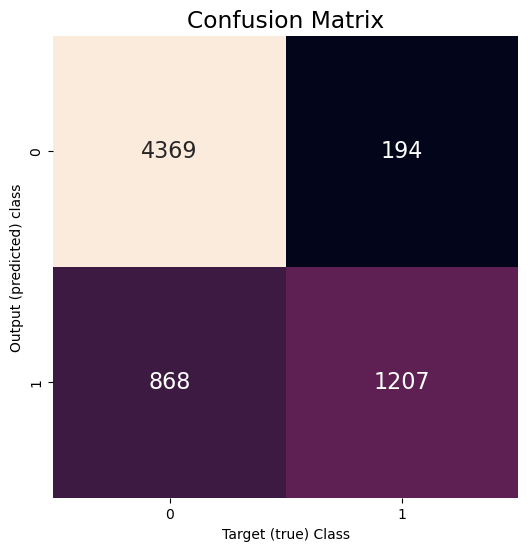

              precision    recall  f1-score   support

       licit       0.83      0.96      0.89      4563
     illicit       0.86      0.58      0.69      2075

    accuracy                           0.84      6638
   macro avg       0.85      0.77      0.79      6638
weighted avg       0.84      0.84      0.83      6638

Test data fraud cases, percentage: 20.97627118644068 %


In [47]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns


gcn_model.load_state_dict(torch.load(os.path.join(Config.checkpoints_dir, 'gcn_best_model.pth.tar'))['state_dict'])

y_test_preds = test(gcn_model, data_train)

# confusion matrix on validation data
y_test = data_train.y[data_train.val_idx].detach().tolist()
y_pred = y_test_preds[valid_idx].detach().tolist()

conf_mat = confusion_matrix(y_test, y_pred)

report_dict = classification_report(y_test, y_pred, output_dict=True)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat, annot=True, fmt=".0f", annot_kws={"size": 16}, cbar=False)
plt.xlabel('Target (true) Class'); plt.ylabel('Output (predicted) class'); plt.title('Confusion Matrix')
plt.show();

print(classification_report(y_test,
                            y_pred,
                            target_names=['licit', 'illicit']))


print(f"Test data fraud cases, percentage: {y_test_preds[data_train.test_idx].detach().cpu().numpy().sum() / len(data_train.y[data_train.test_idx]) *100} %")

In [25]:
fig = ax.get_figure()
fig.savefig("./models/confusion_matrix.png") 
fig.show()
print(report_dict)


In [1]:
def register_python_model(model, name, description, features, labels, metrics):
    from hsml.schema import Schema
    from hsml.model_schema import ModelSchema
    import os
    import joblib
    import shutil

    mr = project.get_model_registry()

    model_dir= name + "_model"
    if os.path.isdir(model_dir) == False:
        os.mkdir(model_dir)
    pickle= name + '_model.pkl'
    # This will strip out the sml directory, copying only the files
    #shutil.copytree("sml", model_dir, dirs_exist_ok=True) #python 3.8+

    joblib.dump(model, model_dir + "/" + pickle)

    input_example = features.sample()
    input_schema = Schema(features)
    output_schema = Schema(labels)
    model_schema = ModelSchema(input_schema, output_schema)

    fraud_model = mr.python.create_model(
        name="fraud", 
        metrics=metrics,
        model_schema=model_schema,
        input_example=input_example, 
        description=description)

    # Save all artifacts in the model directory to the model registry
    fraud_model.save(model_dir)


#register_python_model(gcn_model, "model", "Fraud Predictor", X_train, y_train, report_dict['0.0'])

test 

⏭️ Next:  Graph *export*


In [ ]:
import networkx as nx

df_sim = train_df[train_df['tx_fraud'] == 1]
#print(df_sim.head())

def weekday(tx_datetime):
    
    # Transform date into weekday (0 is Monday, 6 is Sunday)
    weekday = tx_datetime.weekday()
    
    return int(weekday)


df_sim = train_df[train_df['tx_amount'] > 1]
df_sim2 = df_sim[["TX_DATETIME","transaction_id","tx_amount", "customer_id", "terminal_id"]]
df_sim2 = df_sim2.head(10000)

#print(df_sim2.TX_DATETIME)
#print(df_sim2.TX_DATETIME.apply(weekday))


def rolling(df):
    uniques_customer_id = df.customer_id.value_counts().index
    print(uniques_customer_id)
    count = 0
    
    for customer_id in uniques_customer_id:
        dataf = df.loc[df['customer_id'] == int(customer_id) ]
        dataf = dataf.copy()
        dataf.TX_DATETIME =  pd.to_datetime(dataf.TX_DATETIME)
        dataf = dataf.set_index('TX_DATETIME')
        
        if dataf.shape[0] > 5 :
            #print(dataf)
            #val = dataf.rolling('1d', min_periods=2)['tx_amount'].sum()
            #dataf.rolling(1, min_periods=1, step=1).sum()
            dataf.resample('1h')['tx_amount'].sum()
            dataf.resample('D')['tx_amount'].sum()
            dataf.resample('7D')['tx_amount'].sum()
            print(dataf.resample('1h')['tx_amount'].count())
            dataf.resample('D')['tx_amount'].sum()
            dataf.resample('7D')['tx_amount'].sum()
            count = count +1 

        
    print(count)
    return 

rolling(df_sim2)

df_sim2["tx_amount"] = df_sim2["tx_amount"].astype(int)

In [ ]:
G = nx.from_pandas_edgelist(df_sim2, "transaction_id", "customer_id" )


df_attributes_only = df_sim2.copy()
#print(df_attributes_only )
node_attr = df_attributes_only.set_index('transaction_id').to_dict('index')
#print(node_attr)
nx.set_node_attributes(G, node_attr)

#print(df_sim2["tx_amount"].value_counts())

nx.draw(G,node_size =20)
nx.write_gexf(G, "test.gexf")

#https://ouestware.gitlab.io/retina/beta/#/graph/?r=d&url=https%3A%2F%2Fouestware.gitlab.io%2Fretina%2Fbeta%2Fdataset.gexf

⏭️ Next:  Rules *importer*


⏭️ Next:  Feature *engineering* EXT


In [ ]:
jsonsimon = train_df[train_df['tx_fraud'] == 1].head().to_json(orient="columns") #/*".[0-9][0-9][0-9][0-9][0-9]":
parsed = json.loads(jsonsimon)
json.dumps(parsed) 
